# 13 · Model–Model Alignment (discarded from main text)

**Goal.** Quantify how *language* and *vision* DNNs align with each other across depth.  
For every language–vision pair we computed a layer×layer RSA/CKA/KNN grid, interpolated it to a common depth scale (0–100 %), and averaged across pairs to obtain a single smooth “alignment surface” per metric (see Fig. below). This section was dropped for space, but it helps contextualize cross‑modal representational overlap.


## 1. Imports
Load I/O, interpolation, plotting (2D & 3D), and project helpers (`interpolate_alignment_series`, fonts).



In [ ]:
import pandas as pd
from pathlib import Path
from scipy.interpolate import RegularGridInterpolator
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # noqa
import matplotlib.ticker as ticker
from convergence.operations import interpolate_alignment_series
from convergence.figures import setup_matplotlib_fonts
import seaborn as sns

setup_matplotlib_fonts()

## 2. Data
`alignment_model_model_coco.parquet` contains model–model similarity for the  NSD dataset. We use the MS-COCO text captions as language input.
 
Each row: *(model_language, model_vision, layer_language, layer_vision, batch, metric, score)*.  
We will save figures to `figures/13_model_model_alignment/`.


In [5]:
data_folder = Path("../derivatives")

nsd_folder = data_folder / "nsd"
filename_models = nsd_folder / "alignment_model_model_coco.parquet"

figures_folder = Path("../figures")
output_folder = figures_folder / "13_model_model_alignment"
output_folder.mkdir(exist_ok=True)

## 3. Helper functions
- **`process_model_pair`**: pivot to layer×layer matrix, interpolate to a fixed grid (size = max depth across models), return a dense surface.  
- **`interpolate_model_pair`**: loop over image batches, interpolate each, stack into a tensor.  
- **`process_model_combinations`**: iterate over all language×vision pairs and collect their (batch‑averaged) surfaces.  
- **`plot_surface`**: convenience wrapper to display a 3D surface with percent axes.  
(Plus a tiny `unpack_scores` utility kept for completeness.)


In [6]:
def process_model_pair(df_pair_batch, size_language, size_vision, kind="linear"):
    # Get matrix with layer vision in x and layer language in y. Sort by layers in each axis
    matrix = df_pair_batch.pivot(index="layer_language", columns="layer_vision", values="score")
    
    # Check that all layers are present and index and columns are sorted
    if matrix.isna().sum().sum() != 0:
        # If all are in column 0, we can just drop the column
        matrix = matrix.drop(columns=0)
    assert matrix.isna().sum().sum() == 0
    assert all(matrix.index == sorted(matrix.index))
    assert all(matrix.columns == sorted(matrix.columns))
    
    matrix_np = matrix.values
    
    orig_size_language, orig_size_vision = matrix_np.shape
    

    # Interpolate to new size
    x = np.linspace(0, 1, orig_size_language)
    y = np.linspace(0, 1, orig_size_vision)
    f = RegularGridInterpolator((x, y), matrix_np, method=kind)
    x_new = np.linspace(0, 1, size_language)
    y_new = np.linspace(0, 1, size_vision)
    x_new, y_new = np.meshgrid(x_new, y_new, indexing='ij')
    points = np.stack([x_new, y_new], axis=-1)

    matrix_np = f(points)


    assert matrix_np.shape == (size_language, size_vision)

    return matrix_np

def interpolate_model_pair(df, model_language, model_vision, size_language, size_vision, metric="rsa", kind="linear"):
    df_pair = df.query(f"model_language == '{model_language}' and "
                       f"model_vision == '{model_vision}' and "
                       f"metric == '{metric}' and layer_language>=0 and layer_vision>=0")
    batchs = df_pair.batch.unique()
    
    
    surfaces = []

    for batch in batchs:
        df_pair_batch = df_pair.query(f"batch == {batch}")
        interpolated_surface = process_model_pair(df_pair_batch, size_language, size_vision, kind)
        if interpolated_surface is None:
            continue
        surfaces.append(interpolated_surface)
    
    surfaces = np.stack(surfaces, axis=0)
    return surfaces
 
def process_model_combinations(df, metric="rsa", kind="linear"):
    language_models = df.model_language.unique()
    vision_models = df.model_vision.unique()
    max_language_layer = df.layer_language.max()
    max_vision_layer = df.layer_vision.max()
    total = len(language_models) * len(vision_models)
    pbar = tqdm(total=total, leave=False)
    all_surfaces = []
    pairs = []
    for language_model in language_models:
        for vision_model in vision_models:
            surfaces = interpolate_model_pair(
                df,
                model_language=language_model,
                model_vision=vision_model,
                size_language=max_language_layer,
                size_vision=max_vision_layer,
                kind=kind,
                metric=metric
            )
            all_surfaces.append(surfaces)
            pairs.append({"language": language_model,"vision": vision_model})
            pbar.update(1)
    all_surfaces = np.stack(all_surfaces, axis=0)
    pairs = pd.DataFrame(pairs)
    pbar.close()

    return all_surfaces, pairs

def plot_surface(surface, cmap="viridis", downsample=0, **kwargs):
    # Add padding to figure right to avoid cut the zlabel
    fig = plt.figure(figsize=(8, 6), tight_layout={"pad": 1.5})
    ax = fig.add_subplot(111, projection='3d')
    x = np.linspace(0, 1, surface.shape[0])
    
    y = np.linspace(0, 1, surface.shape[1])

    if downsample > 1:
        x = x[::downsample]
        y = y[::downsample]
        surface = surface[::downsample, ::downsample]
    x, y = np.meshgrid(x, y, indexing='ij')
    # Reduce the grid to avoid overlapping labels
    ax.plot_surface(x, y, surface, cmap=cmap, **kwargs)
    
    ax.set_zlim(0, None)
    return fig, ax

def unpack_scores(df):
    dfs = []
    df = df.copy()
    scores = df.scores
    info = df.drop(columns=["scores"])
    
    for t in range(len(scores.values[0])):
        df = info.copy()
        df["score"] = scores.str[t]
        df["layer"] = t
        dfs.append(df)

    df = pd.concat(dfs)
    return df

## 4. Build average surfaces
For each metric (`unbiased_cka`, `mutual_knn`, `rsa`):

1. Filter/clean scores (e.g., drop degenerate CKA = 1 rows).  
2. Interpolate every pair to a common [0,1] grid in both axes.  
3. Stack and average across **all** language–vision pairs (and batches) → one aggregate surface per metric.  

This isolates the *typical* cross‑modal alignment profile, rather than model‑idiosyncratic quirks.


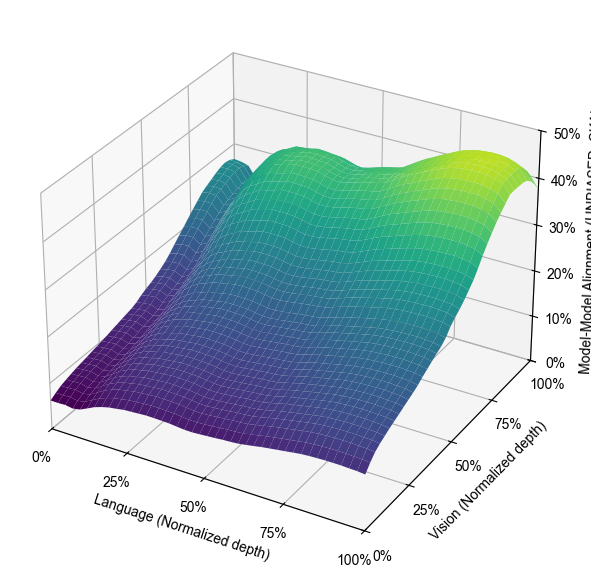

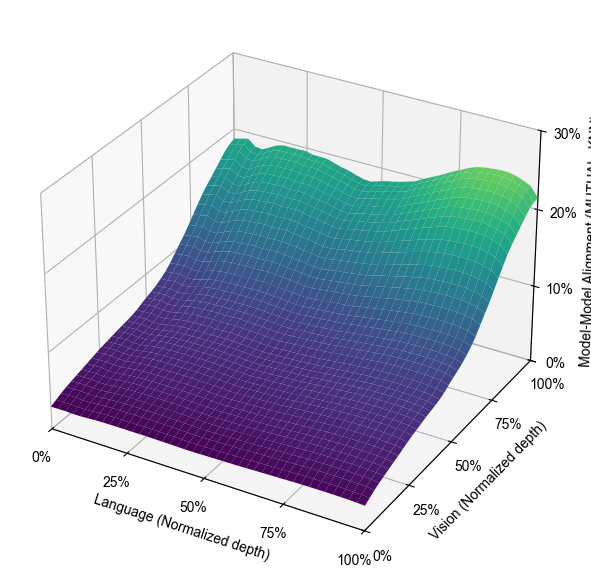

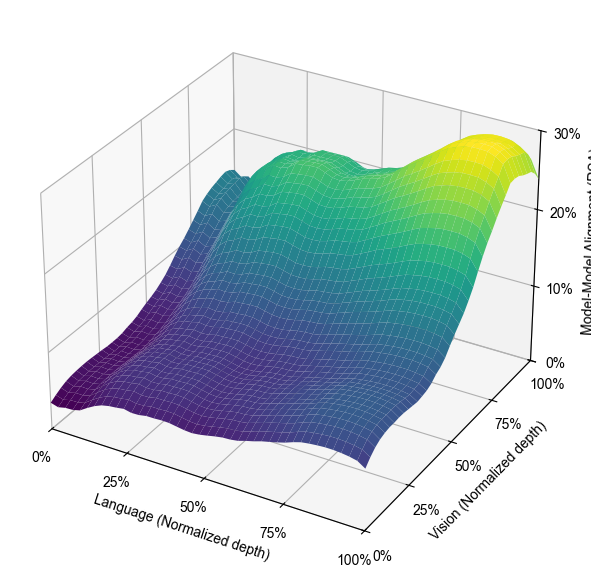

In [ ]:
folder = output_folder
folder.mkdir(exist_ok=True)

lims = {
    'unbiased_cka': 0.5,
    'rsa': 0.3,
    'mutual_knn': 0.3,
}

for metric in ['unbiased_cka', 'mutual_knn', "rsa"]:
    df = pd.read_parquet(filename_models).query(f"metric=='{metric}'")
    # Discard bigscience models bloomz cause instruct training changes alignment
    #df = df[~(df.model_language.str.contains("bigscience") | df.model_language.str.contains("google"))]

    if metric == 'unbiased_cka':
       df = df.query("score < 1 and score > -0.05")

    surfaces, pairs = process_model_combinations(df, metric=metric, kind="linear")
    agg_function = np.mean
    agg_surface = surfaces.mean(axis=0).mean(axis=0)
    vmax = lims[metric]
    fig, ax = plot_surface(agg_surface, antialiased=True, cmap="viridis", vmax=vmax, zorder=1000)
    #ax.set_xlabel("Language layer")
    #ax.set_ylabel("Vision layer")
    ax.zaxis.set_major_formatter(ticker.PercentFormatter(1, 0))
    ax.zaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(0.25))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.25))
    ax.yaxis.set_major_formatter(ticker.PercentFormatter(1, 0))
    ax.xaxis.set_major_formatter(ticker.PercentFormatter(1, 0))
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_zlim(0, vmax)
    ax.set_ylabel("Vision (Normalized depth)", fontsize=10)
    ax.set_xlabel("Language (Normalized depth)", fontsize=10)
    ax.set_zlabel(f"Model-Model Alignment ({metric.upper()})", fontsize=10)

    #ax.set_yticklabels([])
    ax.set_aspect("auto")
    
    fig.savefig(folder / f"01_alignment_{metric}.pdf", dpi=300, transparent=True)



### What do we see?
- **Ridge along deep vision layers**: alignment increases toward later vision stages, regardless of language depth → convergent high‑level visual semantics.  
- **Language depth helps, but modestly**: surfaces gently rise with language depth; the strongest gains come from vision depth.  

Overall, language–vision models share a semantic manifold whose overlap is driven most by the visual pipeline’s later representations.
